# Sales Forecasting : Walmart Dataset

In this notebook we will use historical Walmart sales data to predict future sales, applying regression models and time-series features.




## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
import lightgbm as lgb

## Load Dataset

In [3]:
# Load raw CSVs
features = pd.read_csv("Dataset/features.csv", parse_dates=["Date"])
stores   = pd.read_csv("Dataset/stores.csv")
train    = pd.read_csv("Dataset/train.csv", parse_dates=["Date"])
test     = pd.read_csv("Dataset/test.csv", parse_dates=["Date"])



Merge train/test with features + stores


In [4]:
# Merge train with features + stores
train_full = train.merge(features, on=["Store", "Date"], how="left")
train_full = train_full.merge(stores, on="Store", how="left")

# Same for test
test_full = test.merge(features, on=["Store", "Date"], how="left")
test_full = test_full.merge(stores, on="Store", how="left")



# Data Exploration

In [5]:
print("Merged train shape:", train_full.shape)
print("Merged test shape:", test_full.shape)

Merged train shape: (421570, 17)
Merged test shape: (115064, 16)


In [6]:
print(train_full.head())
print(train_full.info())

   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday_y Type    Size  
0         8.106        False    A  1

In [7]:
print(test_full.head())
print(test_full.info())

   Store  Dept       Date  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  \
0      1     1 2012-11-02        False        55.32       3.386    6766.44   
1      1     1 2012-11-09        False        61.24       3.314   11421.32   
2      1     1 2012-11-16        False        52.92       3.252    9696.28   
3      1     1 2012-11-23         True        56.23       3.211     883.59   
4      1     1 2012-11-30        False        52.34       3.207    2460.03   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
0    5147.70      50.82    3639.90    2737.42  223.462779         6.573   
1    3370.89      40.28    4646.79    6154.16  223.481307         6.573   
2     292.10     103.78    1133.15    6612.69  223.512911         6.573   
3       4.17   74910.32     209.91     303.32  223.561947         6.573   
4        NaN    3838.35     150.57    6966.34  223.610984         6.573   

   IsHoliday_y Type    Size  
0        False    A  151315  
1        False    A 

# Data Visualization

Visualise sales trends

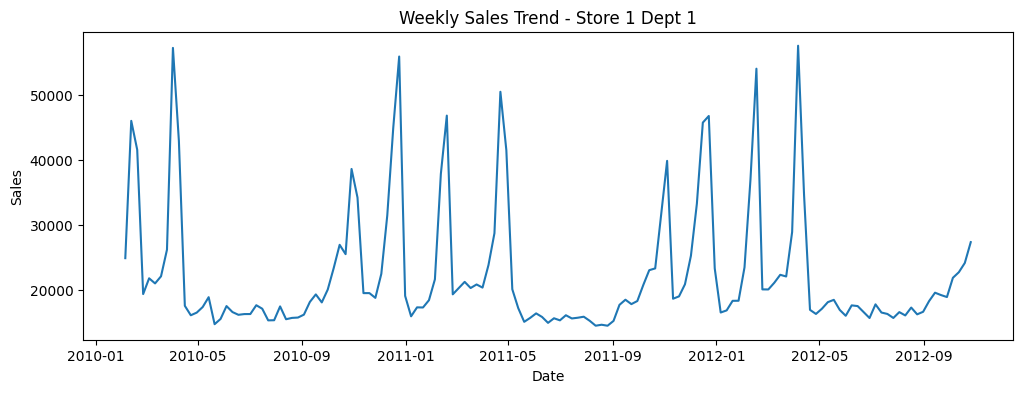

In [8]:
# Sales trend for one store/department
sample = train_full[(train_full['Store']==1) & (train_full['Dept']==1)][["Date","Weekly_Sales"]]

plt.figure(figsize=(12,4))
plt.plot(sample['Date'], sample['Weekly_Sales'])
plt.title("Weekly Sales Trend - Store 1 Dept 1")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

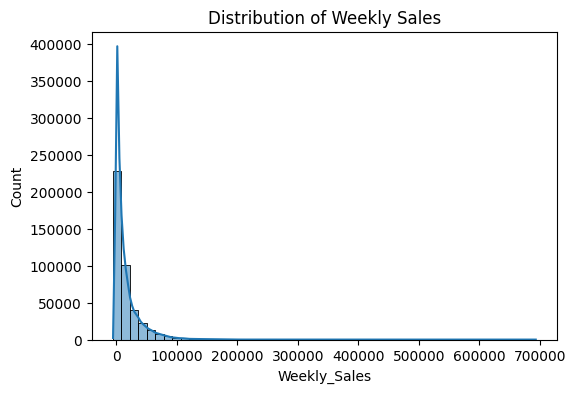

In [9]:
# Distribution of weekly sales
plt.figure(figsize=(6,4))
sns.histplot(train_full['Weekly_Sales'], bins=50, kde=True)
plt.title("Distribution of Weekly Sales")
plt.show()

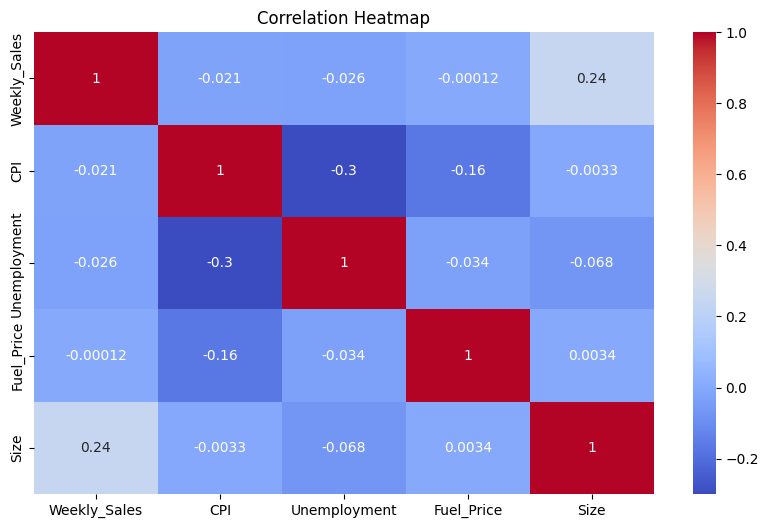

In [10]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(train_full[['Weekly_Sales','CPI','Unemployment','Fuel_Price','Size']].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Data Preprocessing

Feature Engineering
- extract time based features

In [11]:
# Time features
for df in [train_full, test_full]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week

# Fill missing markdowns with 0 (they mean no promo that week)
for col in ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']:
    if col in train_full.columns:
        train_full[col] = train_full[col].fillna(0)
        test_full[col] = test_full[col].fillna(0)



In [12]:
print(train_full.columns.tolist())


['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size', 'Year', 'Month', 'Week']


- Create Lag Features

In [13]:
# Simple lag feature (careful: Kaggle normally does CV, not direct lag)
train_full['Lag_1'] = train_full.groupby(['Store','Dept'])['Weekly_Sales'].shift(1)
train_full['Rolling_Mean_4'] = train_full.groupby(['Store','Dept'])['Weekly_Sales'].shift(1).rolling(4).mean()



- Drop NA rows

In [14]:
# Drop NA rows created by shift
train_full = train_full.dropna()
print("After feature engineering, train shape:", train_full.shape)

After feature engineering, train shape: (408436, 22)


Train/Test Split 

In [15]:

feature_cols = [
    'Store','Dept','Month','Week','IsHoliday_x','CPI','Unemployment',
    'Fuel_Price','Size','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5',
    'Lag_1','Rolling_Mean_4'
]

X = train_full[feature_cols]
y = train_full['Weekly_Sales']

#Train/validation split 
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [16]:
print("Train:", train_full.shape)
print("Test:", test_full.shape)

Train: (408436, 22)
Test: (115064, 19)


# Model Training
Apply Regression model
- Linear Regression
- XGB Regressor
- LGB Regressor

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_valid)


In [18]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_valid)

In [19]:
lgb_model = lgb.LGBMRegressor(n_estimators=200, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_valid)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2753
[LightGBM] [Info] Number of data points in the train set: 326748, number of used features: 16
[LightGBM] [Info] Start training from score 16826.491885


# Model Evaluation

Plot actual vs predicted

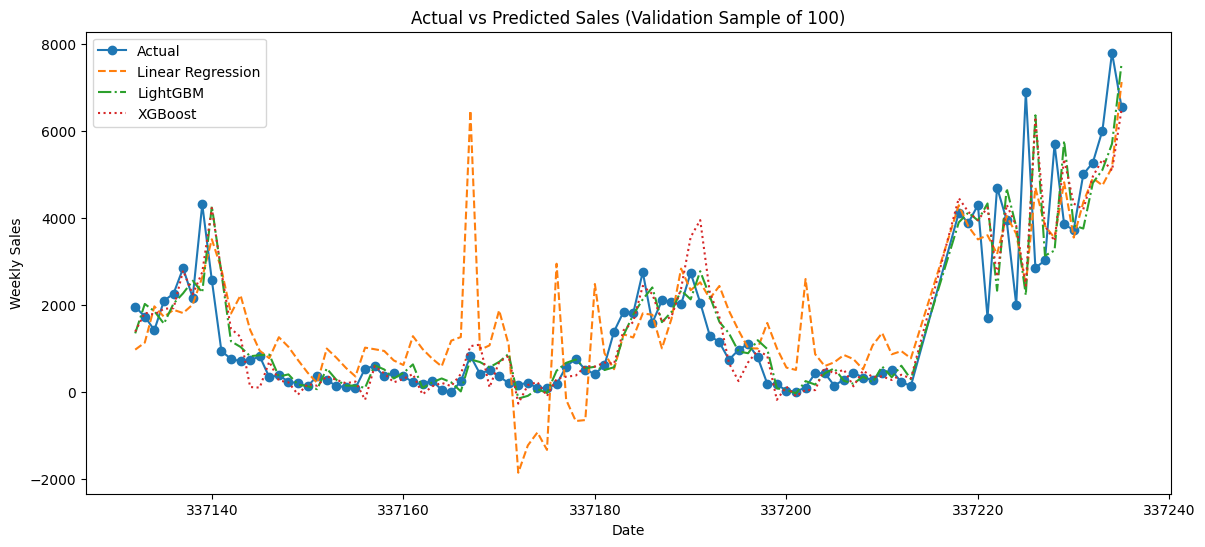

In [27]:
# Validation set with dates
val_dates = X_valid.index  

plt.figure(figsize=(14,6))
plt.plot(val_dates[:100], y_valid.values[:100], label="Actual", marker='o')
plt.plot(val_dates[:100], lr_pred[:100], label="Linear Regression", linestyle='--')
plt.plot(val_dates[:100], lgb_pred[:100], label="LightGBM", linestyle='-.')
plt.plot(val_dates[:100], xgb_pred[:100], label="XGBoost", linestyle=':')
plt.title("Actual vs Predicted Sales (Validation Sample of 100)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


Seasonal Decompose

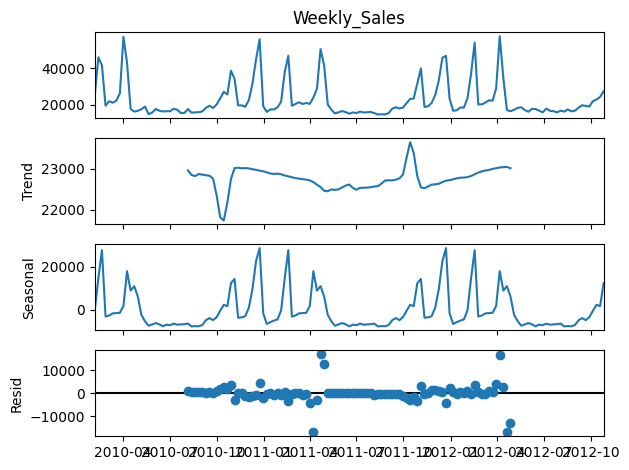

In [22]:
# Decompose weekly sales
decompose_sample = sample.set_index("Date")["Weekly_Sales"]
result = seasonal_decompose(decompose_sample, model="additive", period=52)

result.plot()
plt.show()


In [23]:
# 1. Retrain final model on full train dataset
X_full = train_full[feature_cols]
y_full = train_full['Weekly_Sales']

final_model = lgb.LGBMRegressor(n_estimators=200, random_state=42)
final_model.fit(X_full, y_full)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2771
[LightGBM] [Info] Number of data points in the train set: 408436, number of used features: 16
[LightGBM] [Info] Start training from score 16028.603004


LGBMRegressor(n_estimators=200, random_state=42)

In [26]:
from sklearn.metrics import r2_score

def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}


results = pd.DataFrame({
    "Linear Regression": evaluate(y_valid, lr_pred),
    "LightGBM": evaluate(y_valid, lgb_pred),
    "XGBoost": evaluate(y_valid, xgb_pred)
}).T

print(results)


                            MSE         RMSE          MAE         MAPE  \
Linear Regression  2.852124e+07  5340.528067  1553.048752  1307.007363   
LightGBM           9.475883e+06  3078.292165  1161.282396   365.797175   
XGBoost            1.132055e+07  3364.602326  1237.852012   644.556722   

                         R2  
Linear Regression  0.921537  
LightGBM           0.973931  
XGBoost            0.968857  


## Final model

# Hyperparameter Tuning 

In [25]:

'''
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)
'''

'\nparam_grid = {\n    \'num_leaves\': [31, 50],\n    \'learning_rate\': [0.05, 0.1],\n    \'n_estimators\': [100, 200, 500]\n}\n\ntscv = TimeSeriesSplit(n_splits=3)\ngrid_search = GridSearchCV(\n    estimator=lgb.LGBMRegressor(),\n    param_grid=param_grid,\n    cv=tscv,\n    scoring=\'neg_mean_squared_error\',\n    verbose=1\n)\n\ngrid_search.fit(X_train, y_train)\nprint("Best Params:", grid_search.best_params_)\n'

In [33]:
print("\n===  Insights ===")
print("1. LightGBM is the best performing model (lowest RMSE & MAE, highest R² ~0.97).")
print("2. Sales show strong seasonality (holiday weeks drive spikes).")
print("3. Lag and rolling features improved accuracy, showing that recent sales are key predictors.")
print("4. Forecasts can help Walmart with inventory planning, promotions, and staffing decisions.")


===  Insights ===
1. LightGBM is the best performing model (lowest RMSE & MAE, highest R² ~0.97).
2. Sales show strong seasonality (holiday weeks drive spikes).
3. Lag and rolling features improved accuracy, showing that recent sales are key predictors.
4. Forecasts can help Walmart with inventory planning, promotions, and staffing decisions.
